## Notes on evaluating survival models  

In [1]:
# === Import Libraries ===

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

import scipy.optimize as opt

from sksurv.datasets import load_flchain, load_gbsg2
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv

# === Configure ===
set_config(display="text")  # displays text representation of estimators
plt.rcParams["figure.figsize"] = [7.2, 4.8]

### Bias of Harrel's Coordinate Index

The most frequently used evaluation metric of survival models is the concordance index (c index, c statistic). It is a measure of rank correlation between predicted risk scores 
and observed time points  that is closely related to Kendall’s τ. It is defined as the ratio of correctly ordered (concordant) pairs to comparable pairs. Two samples  and  are
comparable if the sample with lower observed time  experienced an event, i.e., if  and , where  is a binary event indicator. A comparable pair  is concordant if the estimated risk 
by a survival model is higher for subjects with lower survival time, i.e., otherwise the pair is discordant. Harrell’s estimator of the c index is implemented in concordance_index_censored.

Harrel's Coordinate Index is known to be biased upwards when the censoriing in the test data is high. This section will compare this estimator with an alternative to see if it performs better in such a situation.

In [2]:
# === Generate Simulation Study Data ===

def generate_marker(n_samples, hazard_ratio, baseline_hazard, rnd):
    # create synthetic risk score
    X = rnd.randn(n_samples, 1)

    # create linear model
    hazard_ratio = np.array([hazard_ratio])
    logits = np.dot(X, np.log(hazard_ratio))

    # draw actual survival times from exponential distribution,
    # refer to Bender et al. (2005), https://doi.org/10.1002/sim.2059
    u = rnd.uniform(size=n_samples)
    time_event = -np.log(u) / (baseline_hazard * np.exp(logits))

    # compute the actual concordance in the absence of censoring
    X = np.squeeze(X)
    actual = concordance_index_censored(np.ones(n_samples, dtype=bool), time_event, X)
    return X, time_event, actual[0]


def generate_survival_data(n_samples, hazard_ratio, baseline_hazard, percentage_cens, rnd):
    X, time_event, actual_c = generate_marker(n_samples, hazard_ratio, baseline_hazard, rnd)

    def get_observed_time(x):
        rnd_cens = np.random.RandomState(0)
        # draw censoring times
        time_censor = rnd_cens.uniform(high=x, size=n_samples)
        event = time_event < time_censor
        time = np.where(event, time_event, time_censor)
        return event, time

    def censoring_amount(x):
        event, _ = get_observed_time(x)
        cens = 1.0 - event.sum() / event.shape[0]
        return (cens - percentage_cens) ** 2

    # search for upper limit to obtain the desired censoring amount
    res = opt.minimize_scalar(censoring_amount, method="bounded", bounds=(0, time_event.max()))

    # compute observed time
    event, time = get_observed_time(res.x)

    # upper time limit such that the probability
    # of being censored is non-zero for `t > tau`
    tau = time[event].max()
    y = Surv.from_arrays(event=event, time=time)
    mask = time < tau
    X_test = X[mask]
    y_test = y[mask]

    return X_test, y_test, y, actual_c


def simulation(n_samples, hazard_ratio, n_repeats=100):
    measures = (
        "censoring",
        "Harrel's C",
        "Uno's C",
    )
    data_mean = {}
    data_std = {}
    for measure in measures:
        data_mean[measure] = []
        data_std[measure] = []

    rnd = np.random.RandomState(seed=987)
    # iterate over different amount of censoring
    for cens in (0.1, 0.25, 0.4, 0.5, 0.6, 0.7):
        data = {
            "censoring": [],
            "Harrel's C": [],
            "Uno's C": [],
        }

        # repeaditly perform simulation
        for _ in range(n_repeats):
            # generate data
            X_test, y_test, y_train, actual_c = generate_survival_data(
                n_samples, hazard_ratio, baseline_hazard=0.1, percentage_cens=cens, rnd=rnd
            )

            # estimate c-index
            c_harrell = concordance_index_censored(y_test["event"], y_test["time"], X_test)
            c_uno = concordance_index_ipcw(y_train, y_test, X_test)

            # save results
            data["censoring"].append(100.0 - y_test["event"].sum() * 100.0 / y_test.shape[0])
            data["Harrel's C"].append(actual_c - c_harrell[0])
            data["Uno's C"].append(actual_c - c_uno[0])

        # aggregate results
        for key, values in data.items():
            data_mean[key].append(np.mean(data[key]))
            data_std[key].append(np.std(data[key], ddof=1))

    data_mean = pd.DataFrame.from_dict(data_mean)
    data_std = pd.DataFrame.from_dict(data_std)
    return data_mean, data_std


def plot_results(data_mean, data_std, **kwargs):
    index = pd.Index(data_mean["censoring"].round(3), name="mean percentage censoring")
    for df in (data_mean, data_std):
        df.drop("censoring", axis=1, inplace=True)
        df.index = index

    ax = data_mean.plot.bar(yerr=data_std, **kwargs)
    ax.set_ylabel("Actual C - Estimated C")
    ax.yaxis.grid(True)
    ax.axhline(0.0, color="gray")

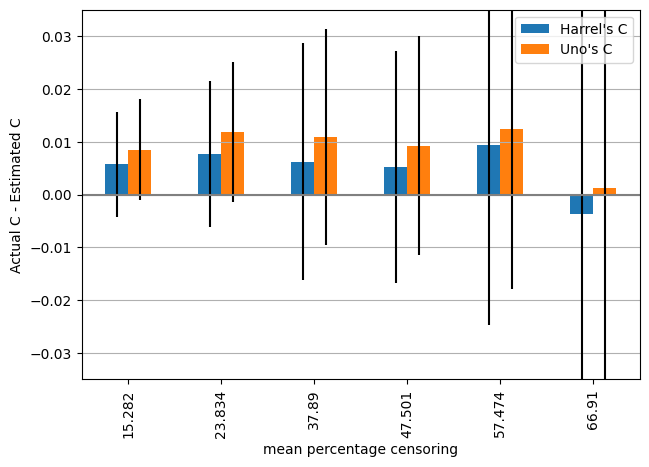

In [3]:
# Run Simulation 

hazard_ratio = 2.0
ylim = [-0.035, 0.035]
mean_1, std_1 = simulation(100, hazard_ratio)
plot_results(mean_1, std_1, ylim=ylim)